In [70]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
# Check for GPU
if tf.config.list_physical_devices('GPU'):
    print('GPU available')
else:
    print('GPU not found')

GPU available


In [3]:
#check if dataset is available
target_dataset = 'malaria'
print(target_dataset in tfds.list_builders())

True


In [4]:
#Download and load dataset into train and test sets
(train_data,test_data),ds_info=tfds.load(target_dataset, 
                                         as_supervised=True,
                                         shuffle_files=True,
                                         split=['train[:80%]','train[:20%]'],
                                         with_info=True,
                                         batch_size=None)

In [5]:
len(train_data) ,len(test_data)

(22046, 5512)

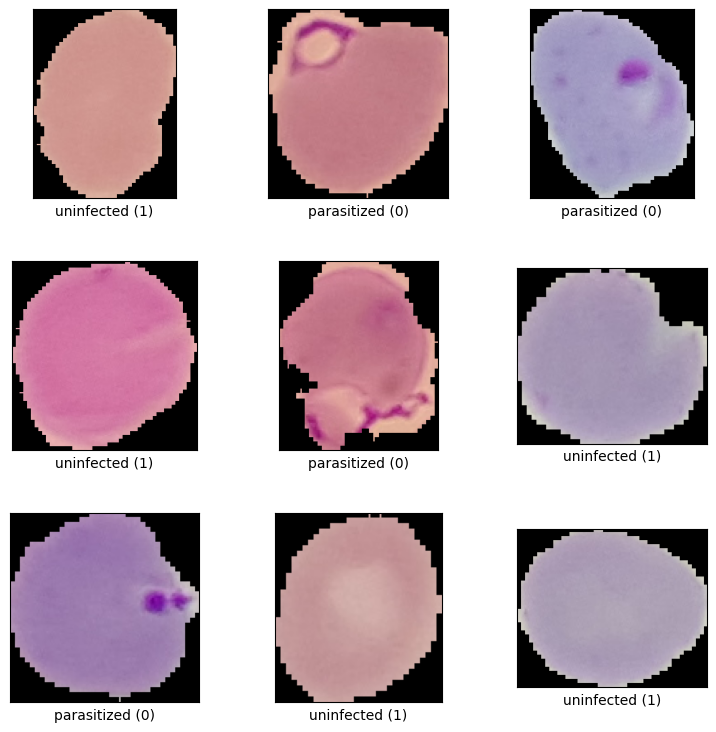

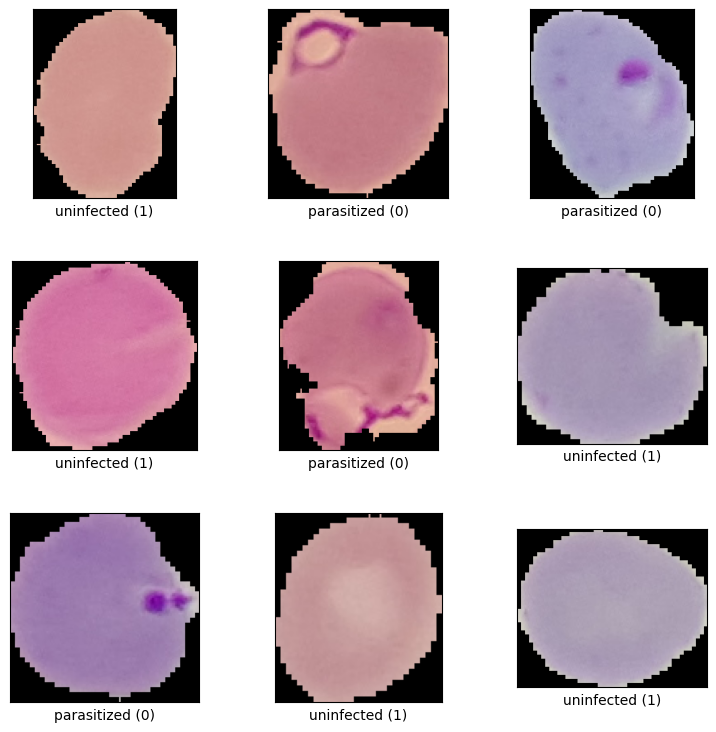

In [6]:
tfds.visualization.show_examples(train_data, ds_info)

In [7]:
for image, label in train_data.take(1):
    print(image.dtype, image.shape,tf.reduce_min(image), tf.reduce_max(image))

<dtype: 'uint8'> (145, 148, 3) tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(201, shape=(), dtype=uint8)


In [12]:
def preprocess_images(img, label):
    resizing = layers.Resizing(100,100)
    img = resizing(img)
    return tf.cast(img, tf.float32), label

In [13]:
train_data_float32 = train_data.map(map_func=preprocess_images)
test_data_float32 = test_data.map(map_func=preprocess_images)

In [14]:
for image, label in train_data_float32.take(1):
    print(image.dtype, image.shape,tf.reduce_min(image), tf.reduce_max(image))

<dtype: 'float32'> (100, 100, 3) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(196.295, shape=(), dtype=float32)


In [25]:
train_dataset = train_data_float32.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data_float32.batch(32).prefetch(tf.data.AUTOTUNE)

In [52]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=(100,100,3), dtype=tf.float32)
x = base_model(inputs, training=False)
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_0 = tf.keras.Model(inputs, outputs)

In [53]:
model_0.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 16)          184336    
                                                                 
 global_average_pooling2d_5   (None, 16)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,103,665
Trainable params: 184,353
Non-train

In [54]:
model_0.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [55]:
model_0_history=model_0.fit(train_dataset, 
            epochs=5, 
            steps_per_epoch=len(train_dataset),
            validation_data=test_dataset,
            validation_steps=int(0.1*len(test_dataset)))

Epoch 1/5
689/689 [==============================] - 18s 19ms/step - loss: 0.1842 - accuracy: 0.9278 - val_loss: 0.1342 - val_accuracy: 0.9485
Epoch 2/5
689/689 [==============================] - 13s 18ms/step - loss: 0.1380 - accuracy: 0.9478 - val_loss: 0.1176 - val_accuracy: 0.9577
Epoch 3/5
689/689 [==============================] - 13s 18ms/step - loss: 0.1186 - accuracy: 0.9557 - val_loss: 0.0955 - val_accuracy: 0.9614
Epoch 4/5
689/689 [==============================] - 12s 18ms/step - loss: 0.1012 - accuracy: 0.9636 - val_loss: 0.0878 - val_accuracy: 0.9577
Epoch 5/5
689/689 [==============================] - 12s 18ms/step - loss: 0.0855 - accuracy: 0.9697 - val_loss: 0.0852 - val_accuracy: 0.9632


In [56]:
model_0_results = model_0.evaluate(test_dataset)

173/173 [==============================] - 3s 17ms/step - loss: 0.0891 - accuracy: 0.9655


In [58]:
# Make some predictions
model_0_pred_probs = model_0.predict(test_dataset)

173/173 [==============================] - 4s 17ms/step


In [59]:
model_0_preds = tf.squeeze(tf.round(model_0_pred_probs))

In [63]:
true_categories = tf.concat([y for x, y in test_dataset], axis=0)

In [64]:
cm  = confusion_matrix(true_categories, model_0_preds)

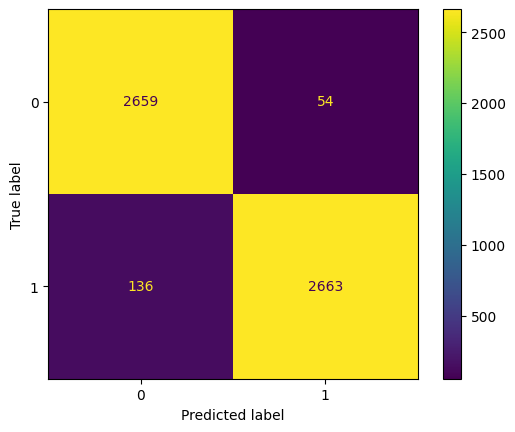

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2713
           1       0.98      0.95      0.97      2799

    accuracy                           0.97      5512
   macro avg       0.97      0.97      0.97      5512
weighted avg       0.97      0.97      0.97      5512



In [71]:
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(true_categories, model_0_preds))